# Predicting Property Prices From Zillow Data

## Key Takeaways

- Major factors determining property price are:
    - square feet
    - number of bathrooms/bedrooms
    - year built


## Contents <a name='contents'></a>

*Note: the following links will only work on local copies of this notebook.*

1. <a href='#introduction'>Introduction</a>
2. <a href='#wrangle'>Wrangle Data</a>
    1. <a href='#acquire'>Acquire the Data</a>
    2. <a href='#prepare'>Prepare and Clean the Data</a>
3. <a href='#explore'>Explore Data</a>
    1. <a href='#hypothesis1'>Are `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` related?</a>
    2. <a href='#hypothesis2'>What is the connection between `bedroomcnt`, `bathroomcnt` and `taxvaluedollarcnt`?</a>
    
The following modules are used in this notebook:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import wrangle
import explore

## Introduction <a name='introduction'></a>

Zillow data was pulled from the database, and analyzed to determine which features can best determine the property value of a house.  This project is divided into three parts: wrangle, explore, and model.  Wrangle explains how the data is acquired and prepared for analysis and processing.  Explore looks at the data and applies visualization and hypothesis testing to discover drivers of the property value.  Finally, model builds a linear regression model to predict property values from the data. Each section and select subsections include a short list of key takeaways; these are followed by a discussion detailing the analysis choices made that are relevant to that (sub)section.

### Goals
- Test at least four drivers of the property value, so that the data and the model predictions can be better understood
- Wrangle data to prepare it for analysis, so that the data pulled in the future can be wrangled in a similar manner
- Build a model that beat the baseline models, so that Zillow can display information to the users of its website
- Include a report for future reference so that this project can be built upon in the future

### Project Plan
- Explore at least four variables of property prices
- Visualize variables
- Hypothesis test at least two variables
- Write this final report
- Python scripts that allow for the project to be reproducible

<a href='#contents'>Back to contents</a>

## Wrangle Data <a name='wrangle'></a>

#### Key Wrangle  Takeaways

- $\approx0.98$ of the data is retained or the original 52,441 rows
- 10 of the 59 rows are retained
- Data is acquired from the SQL database
- Any column with $> 0.01$ of nulls is dropped
- Redundant and innaccurate columns with significant missing data are removed
- Extreme outliers are removed from the data; this was determined based off of the typical customer of Zillow.
- Any remaining null valued rows are dropped

<a href='#contents'>Back to contents</a>

### Acquire the data <a name='acquire'></a>

#### Key Acquire Takeaways

- `wrangle.get_zillow_data()` is used to get the data from the database.
- 58 columns and 52441 rows are imported from the data

#### Discussion

Below the data is acquired via the `wrangle.get_zillow_data()` function. This function will query the SQL database, unless there is a saved .csv file present in the current directory.  The name of the file is set by the `wrangle.FILENAME` constant. This function has the following parameters:
- `query_db = False` (bool) : forces a query to the SQL database even if the .csv file is present.

In [2]:
df = wrangle.get_zillow_data() #acquire database via the database or saved .csv file
df.sample(3) #display three lines of the data

Returning saved csv file.


,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
14611,1409786,12499944,1.0,NaN,NaN,2.0,2.0,NaN,6.0,2.0,...,NaN,NaN,97000.0,485000.0,2016.0,388000.0,5788.09,NaN,NaN,6.037572e+13
39161,2307312,13981980,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,2.0,NaN,245358.0,1485455.0,2016.0,1240097.0,16027.02,NaN,NaN,6.059063e+13
41558,459420,14245030,13.0,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,1.0,NaN,143438.0,749000.0,2016.0,605562.0,8419.16,NaN,NaN,6.059076e+13


Determine the shape of the dataframe.  This tuple will be used later to calculate the percent of data retained after cleaning.

In [3]:
original_shape = df.shape #get the shape attribute of the dataframe
original_shape # display the variable contents

(52441, 59)

In order to determine the extent of missing data, `wrangle.return_col_percent_null()` is used. The function has the followng parameters:
- `df` (DataFrame) : a dataframe containing the Zillow data

This function will return a dataframe with the following columns:
- `column_name` : The name of the column of the relevant column of `df`
- `percent_null` : The percent of rows in the `column_name` column of `df` that are null values
- `count_null` : The total number of null values in the `column_name` column of `df`

The output of the function is as follows.

In [20]:
null_proportion_df = wrangle.return_col_percent_null(df) #call the custom function
null_proportion_df.sample(3) #display the dataframe

,column_name,percent_null,count_null
6,lotsizesquarefeet,0.0,0
1,bathroomcnt,0.0,0
9,county,0.0,0


<a href='#contents'>Back to contents</a>

### Prepare and Clean the Data <a name='prepare'></a>

#### Key Prepare and Clean Takeaways
- $\approx0.98$ of the data is retained
- Columns with high percentage of nulls are dropped
- Redundant and innacurate data is also dropped
- Extreme outliers and remaining null valued rows are dropped
- `fips` values are converted to equivalent county names
- `latitude` and `longitude` are made into correct values

Consider the columns that have greater tha $0.01$ of the rows having null values. Because there is significant data missing, all of these columns will be dropped.  Note, however, that some of these columns do have the majority of their data.  These columns could be used in a future analysis, see the <a href='#conclusion'>conclusion</a> for more discussion. The `null_proportion_df` is used to display these columns.

In [5]:
null_proportion_df[null_proportion_df.percent_null > 0.01]

,column_name,percent_null,count_null
2,airconditioningtypeid,0.7399,38803
3,architecturalstyletypeid,0.9987,52371
4,basementsqft,0.9991,52394
7,buildingclasstypeid,1.0000,52441
8,buildingqualitytypeid,0.3566,18701
10,decktypeid,0.9926,52052
11,finishedfloor1squarefeet,0.9165,48060
14,finishedsquarefeet13,1.0000,52441
15,finishedsquarefeet15,1.0000,52441
16,finishedsquarefeet50,0.9165,48060


Some of the remaining columns contain significant outliers. These can be dropped Consider the following columns:
- `bathroomcnt` : Most houses for Zillow users will have at most 6 bathrooms; any rows with more than 6 bathrooms are dropped.  In addition, any row that reports no bathrooms is dropped
- `bedroomcnt` : Similar to the number of bathrooms, any rows with no bedrooms or more than 6 bedrooms is dropped.  A typical homebuyer will not have more than 6 bedrooms.
- `calculatedfinishedsquarefeet` : Houses with less than 150 square feet or more than 6000 square feet are excluded from the analysis. Most of the rows are much smaller than this, and a typical user will not be interested in this type of house.
- `lotsizesquarefeet` : Any lot that is over 5 acres is excluded.  Most houses are on lots a fifth of the size.

Note that this continues to leave a significant number of outliers in the dataset; however, these provide more "mainstream" customers.

The following boxplots show the extent of these outliers:

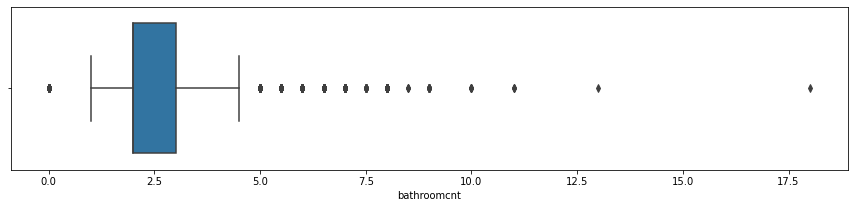

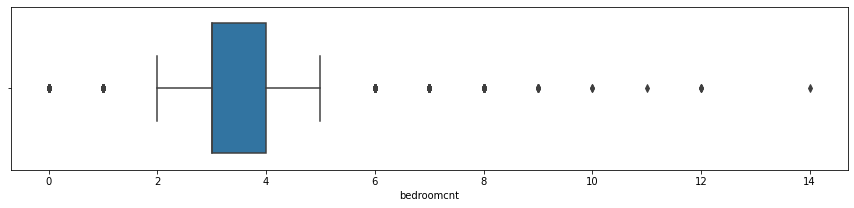

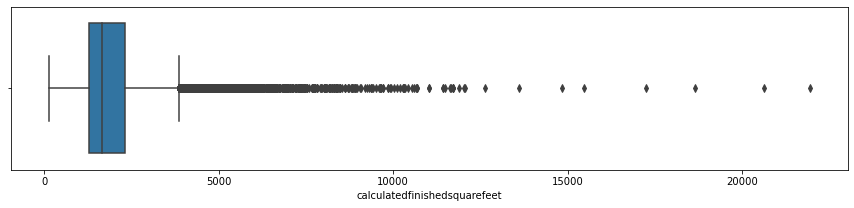

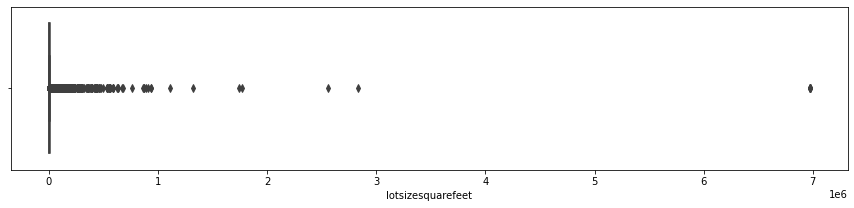

In [6]:
#columns to plot
columns_boxplot = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet']
for col in columns_boxplot:
    #size the figure
    plt.figure(figsize=(15,3))
    #make a boxplot
    sns.boxplot(x=col, data=df)
    #label the boxplot
    plt.xlabel(col)
    #display the boxplot
    plt.show()

The above information is also displayed in numeric form below.

In [7]:
df[columns_boxplot].describe() #describe the relevant columns

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet
count,52441.000000,52441.000000,52359.000000,5.207200e+04
mean,2.299403,3.300681,1922.890754,1.133962e+04
std,1.022772,0.949094,1004.365838,8.674763e+04
min,0.000000,0.000000,128.000000,2.360000e+02
25%,2.000000,3.000000,1268.000000,5.583000e+03
50%,2.000000,3.000000,1659.000000,6.840500e+03
75%,3.000000,4.000000,2306.000000,8.798250e+03
max,18.000000,14.000000,21929.000000,6.971010e+06


Redundant data can also be dropped.  Consider the following columns:
- `calculatedbathnbr` and `fullbathcnt`, the data can be calculated from the other two columns
- `finishedsquarefeet12` is a repetition of `calculatedfinishedsquarefeet`
- `assessmentyear` can calso be dropped as it is all the same value, 2016.
- `rmcnt` contains significant missing values are can be inferred from the seemingly more reliable `bedroomcnt` and `bathroomcnt`

As an illustration, consider the `rmcnt` column.  It should be at least the sum of `bathroomcnt` and `bedroomcnt`, but isn't always.  In $0.26$ of the rows the data is wrong, assuming the counts for `bathroomcnt` and `bedroomcnt` are accurate.  

In [8]:
#Get the percent of rows where roomcnt is more than the sum of bedroomcnt and bathroomcnt
(df['roomcnt'] >= (df['bathroomcnt']+df['bedroomcnt'])).mean()

0.2617608359871093

Some of the data is not accurate.  Consider the `regionidzip` column.  It contains values that are outside of the range of zip code values for California:

In [9]:
df[['regionidzip']].describe() # display the stats for the column

,regionidzip
count,52415.000000
mean,96635.846380
std,4605.107533
min,95982.000000
25%,96206.000000
50%,96412.000000
75%,96995.000000
max,399675.000000


Some of the data is also in the wrong form.  For example `latitude` and `longitude` need to be multiplied by $10^{-6}$ to get values that are in the range for southern California.  This is illustrated by the first few rows.

In [10]:
df[['latitude', 'longitude']].head(3)

,latitude,longitude
0,33879703.0,-118406604.0
1,33976669.0,-117834686.0
2,33990330.0,-118414200.0


The `fips` column can also be mapped to the relevant county names of Los Angeles, Ventura and Orange.

Some columns contain useful information, but that would be outside of the scope of this project, see <a href='#conclusion'>conclusion</a> for a discussion.  These columns are dropped:
- `censustractandblock` and `rawcensustractandblock` are dropped
- `propertycountylandusecode` might be useful, but determing its meaning is outside of the scope of this project

Foreign key rows are dropped.  These are:
- `propertylandusetypeid`
- `regionidcounty`
- `id` : `parcelid` is used to identify rows instead.

Data leakage columns are also dropped.  these are `taxamount` and `structuretaxvaluedollarcnt`.

The remaining rows that have nulls are dropped as they represent a small ($ < 0.01$ of the data in the rows).

`wrangle.wrangle_zillow()` is used to drop the columns, fix the values and drop the null valued rows. Is takes as a parameter `df`, a dataframe object. It uses the following functions:
- `wrangle.zillow_drop_columns()` : drops the columns using `wrangle.COLUMNS_TO_DROP` module constant (see <a href='#appendix'>appendix</a> for more information on the constants of the `wrangle.py` module.
- `wrangle.prepare_zillow_data()` : removes null valued rows, outliers and fixes the `latitude`, `longitude`, and `fips` columns.  In additon, it casts the datatypes to more efficient data types (typically some size of a `uint`)

In [11]:
df = wrangle.wrangle_zillow(df) #call the function that cleans and prepares the data
df.sample(3) #display some rows

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,county
11820,11083224,3.0,4,2242,34.259968,-118.516774,7792.0,1979,604073,Los Angeles
4097,14481309,2.0,2,1631,33.616104,-117.584082,4950.0,1987,647208,Orange
23503,10951150,1.0,3,1028,34.197818,-118.329620,6046.0,1943,453060,Los Angeles


In [13]:
wrangle.return_col_percent_null(df)

,column_name,percent_null,count_null
0,parcelid,0.0,0
1,bathroomcnt,0.0,0
2,bedroomcnt,0.0,0
3,calculatedfinishedsquarefeet,0.0,0
4,latitude,0.0,0
5,longitude,0.0,0
6,lotsizesquarefeet,0.0,0
7,yearbuilt,0.0,0
8,taxvaluedollarcnt,0.0,0
9,county,0.0,0


There are no more nulls in the resulting dataframe.

In [12]:
(df.shape[0])/original_shape[0]

0.9781468698156023

$\approx0.98$ of the data is retained.

<a href='#contents'>Back to contents</a>

## Explore <a name='explore'></a>
- Data is split into `train`, `validate` and `test`
- All hypothesis testing is done use $α = 0.05$ 
- `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` are highly positively correlated
- `bedroomcnt` and `bathroomcnt` are correlated with `taxvaluedollarcnt`, but `bathroomcnt` is particularly correlated.  It might be better to only pass `bathroomcnt` in the model. 

This section uses the `explore.py` module which includes the following functions:
- `plot_variable_pairs()` plots all the pairs of variables possible and includes a regression line displayed in red.  it has the following parameters:
    - `df` (DataFrame) : a dataframe object
    - `columns_x` (list) : a list of column names to plot on the x-axis
    - `columns_y` (list) : a list of column names to plot on the y-axis
    - `sampling` (int) : the number of points from the data to plot
- `r_values_vars()` performs a pearson r correlation test on all the possible pairs of columns that are passed. It returns a dataframe containing the column names, the r-value, the p-value and a boolean representing if the null hypothesis can be rejected. It has the following parameters:
    - `df` (DataFrame) : a Dataframe object
    - `columns` (list) : the columns to hypothesis test

Before the exploration stange it is important to split the data into train, validate and test subsets.  This is done using the `wrangle.split_zillow_data()` function.  This function takes as its parameter `df` a dataframe object and returns three DataFrames: `train`, `validate` and `test`; these three dataframes are of descending size.

In [18]:
train, validate, test = wrangle.split_zillow_data(df) #split the data and store the returns in variables
train.shape[0], validate.shape[0], test.shape[0] #display the number of rows in each dataframe

(28725, 12311, 10259)

### Are `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` related? <a name='hypothesis1'></a>

Generally, bigger homes cost more than smaller homes.  Consider the following graph that includes the regression line in red.

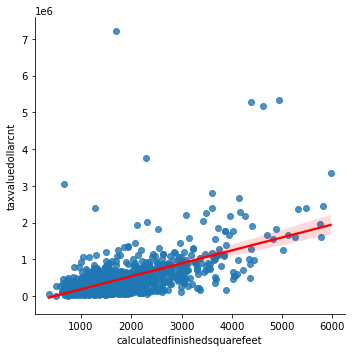

In [17]:
explore.plot_variable_pairs(train, columns_y=['taxvaluedollarcnt'], columns_x=['calculatedfinishedsquarefeet'])

There appears to be a strong positive correlation.  Consider the following null and alternative hypothesis:

$H_0$ : `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` are not correlated

$H_a$ : `calculatedfinishedsquarefeet` and `taxvaluedollarcnt` are correlated

This can be tested using the `explore.r_values_vars()` function.

In [19]:
explore.r_values_vars(train, columns = ['taxvaluedollarcnt', 'calculatedfinishedsquarefeet'])

,correlation,r,p-value,reject_null
0,taxvaluedollarcnt x calculatedfinishedsquarefeet,0.552838,0.0,True


The p-value is low likely due to the size of the dataframe.  $H_0$ is likely false, and $H_a$ is likely true.

<a href='#contents'>Back to contents</a>

### What is the connection between `bedroomcnt`, `bathroomcnt` and `taxvaluedollarcnt`? <a name='hypothesis2'></a>

The number of bedroom and the number of bathrooms a house has correlated with the size of the house.  However, it might be the case that more expensive houses have more bathrooms, and likely more bedrooms.  In addition, it might be the case that more expensive houses have a lower ratio between bedrooms to bathroom -- that is, an expenisve house is more likely to have an ensuite bathroom for more bedrooms.

First, consider the correlation between `bedroomcnt` and `taxvaluedollarcnt`.  Consider the following graph:

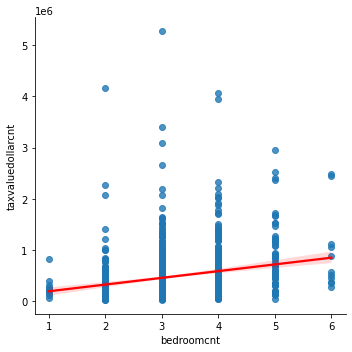

In [22]:
explore.plot_variable_pairs(train, columns_y=['taxvaluedollarcnt'], columns_x=['bedroomcnt'])

Consider the following hypothesis:

$H_0$ : `bedroomcnt` and `taxvaluedollarcnt` are unrelated

$H_a$ : `bedroomcnt` and `taxvaluedollarcnt` are related

Run a hypothesis test:

In [23]:
explore.r_values_vars(train, columns = ['taxvaluedollarcnt', 'bedroomcnt'])

,correlation,r,p-value,reject_null
0,taxvaluedollarcnt x bedroomcnt,0.240511,0.0,True


$H_0$ is likely false.  However, the r-value is not particularly high.

Now consider the correlation between `bathroomcnt` and `taxvaluedollarcnt`.  Consider the following graph:

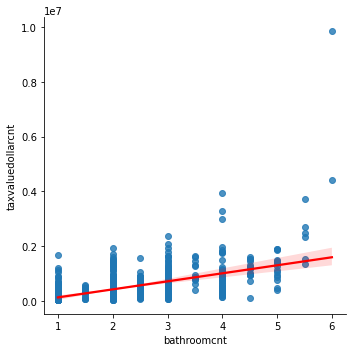

In [24]:
explore.plot_variable_pairs(train, columns_y=['taxvaluedollarcnt'], columns_x=['bathroomcnt'])

Consider the following hypothesis:

$H_0$ : `bathroomcnt` and `taxvaluedollarcnt` are unrelated

$H_a$ : `bathroomcnt` and `taxvaluedollarcnt` are related

Run a hypothesis test:

In [26]:
explore.r_values_vars(train, columns = ['taxvaluedollarcnt', 'bathroomcnt'])

,correlation,r,p-value,reject_null
0,taxvaluedollarcnt x bathroomcnt,0.493155,0.0,True


$H_0$ is likely false.  The r-value is much higher than the correlation with `bedroomcnt`.  

Consider the ratio between `bedroomcnt` and `bathroomcnt` defined as $\text{ratio} = \frac{\text{`bathroomcnt`}}{\text{`bedroomcnt`}}$.  If the ratio is low then `taxvaluedollarcnt` is most likely higher.

Make a column first:

In [35]:
train['bed_bath_ratio'] = train['bedroomcnt']/train['bathroomcnt']

Graph the column

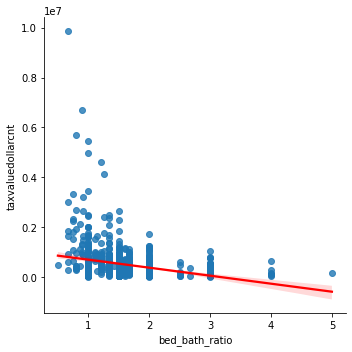

In [39]:
explore.plot_variable_pairs(train, columns_y=['taxvaluedollarcnt'], columns_x=['bed_bath_ratio'])

It looks like thhere is a correlation.  Consider the following hypothesis:

$H_0$ : There is no correlation between the bedroom-bathroom ratio and `taxvaluedollarcnt`

$H_a$ : There is a correlation between the bedroom-bathroom ratio and `taxvaluedollarcnt`

Run the hypothesis test:

In [40]:
explore.r_values_vars(train, columns = ['taxvaluedollarcnt', 'bed_bath_ratio'])

,correlation,r,p-value,reject_null
0,taxvaluedollarcnt x bed_bath_ratio,-0.294967,0.0,True


$H_0$ is likely false. In addition the correlation is negative, as expected.  However, the correlation is not very high. 

It is worth considering a `min_rooms` defined as $\text{`bedroomcnt`} + \text{`bathroomcnt`}$.  Note that this is similar to the dropped `roomcnt` but will not have null values.  The houses will have at least `min_rooms`; this means that `bedroomcnt` and `bathroomcnt` can be dropped.

First make the column:

In [42]:
train['min_rooms'] = train['bedroomcnt'] + train['bathroomcnt']

Graph the column:

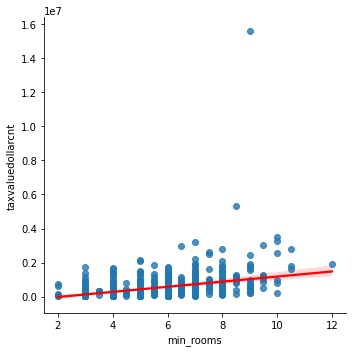

In [43]:
explore.plot_variable_pairs(train, columns_y=['taxvaluedollarcnt'], columns_x=['min_rooms'])

It looks like thhere is a correlation.  Consider the following hypothesis:

$H_0$ : There is no correlation between `min_rooms` and `taxvaluedollarcnt`

$H_a$ : There is a correlation between `min_rooms` and `taxvaluedollarcnt`

Run the hypothesis test:

In [44]:
explore.r_values_vars(train, columns = ['taxvaluedollarcnt', 'min_rooms'])

,correlation,r,p-value,reject_null
0,taxvaluedollarcnt x min_rooms,0.409705,0.0,True


$H_0$ is likely false.  But the correlation is not very strong.  However, there is probably colinearity at work; therefore, `bedroomcnt` and `calculatedfinishedsquarefeet` might be columns to not train a model on.  Alternatively, keep `bathroomcnt` and consider the number of square feet to the number of bathrooms.